# Bike Sharing Demand Prediction using HistGradientBoostingRegressor
This notebook presents a regression model to predict daily bike rentals using the UCI Bike Sharing Dataset (day.csv).

In [1]:
# Imports Required Libraries
# Standard libraries for data manipulation and analysis
import pandas as pd
import numpy as np
# Libraries for data splitting, preprocessing, and model evaluation
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
# Metrics to evaluate regression model performance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
# Regression models
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    BaggingRegressor,
    HistGradientBoostingRegressor,
    ExtraTreesRegressor,
    AdaBoostRegressor
)
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
# Visualization libraries for exploratory data analysis and model insights
import matplotlib.pyplot as plt
import seaborn as sns
# Importing the 'os' module, which provides functionality to interact with the operating system
import os
# Handling file paths and directories in a platform-independent way
from pathlib import Path

# Data is split into training and testing sets to evaluate the model's ability to generalize to unseen data.
# Scaling is necessary to standardize features, ensuring that each feature contributes equally to the model.

ModuleNotFoundError: No module named 'pandas'

In [34]:
# Retrieve and print the current working directory (CWD) to ensure correct file paths
print(os.getcwd())

D:\buc\ai\assignment\Bike_Sharing_Demand_prediction


In [35]:
# Using 'Path' from pathlib for easy and platform-independent handling of file paths
directory_path = Path("D:/buc/ai/assignment/Bike_Sharing_Demand_prediction") # relative path to local directory
files = [file.name for file in directory_path.iterdir() if file.is_file()]
# Output the list of filenames to verify the contents of the directory
print(files)

['Bike_Sharing_HistGradientBoosting_Regressor.ipynb', 'day.csv', 'README.md']


## 1. Load and Inspect Dataset

In [36]:
# Load the re-uploaded dataset
file_path = "day.csv"
df = pd.read_csv(file_path, sep=',')
pd.set_option('display.max_columns', None)
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.34,0.36,0.81,0.16,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.36,0.35,0.70,0.25,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.20,0.19,0.44,0.25,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.20,0.21,0.59,0.16,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.23,0.23,0.44,0.19,82,1518,1600


In [37]:
# Display concise summary information about the DataFrame, including data types,
# column names, non-null counts, and memory usage. Useful for identifying missing data and data types.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  atemp       731 non-null    float64
 11  hum         731 non-null    float64
 12  windspeed   731 non-null    float64
 13  casual      731 non-null    int64  
 14  registered  731 non-null    int64  
 15  cnt         731 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB


In [38]:
# Generate descriptive statistics that summarize the central tendency, dispersion,
# and shape of the DataFrame's numeric columns, aiding in initial exploratory data analysis.
df.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,731.00,731.00,731.00,731.00,731.00,731.00,731.00,731.00,731.00,731.00,731.00,731.00,731.00,731.00,731.00
mean,366.00,2.50,0.50,6.52,0.03,3.00,0.68,1.40,0.50,0.47,0.63,0.19,848.18,3656.17,4504.35
std,211.17,1.11,0.50,3.45,0.17,2.00,0.47,0.54,0.18,0.16,0.14,0.08,686.62,1560.26,1937.21
min,1.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.06,0.08,0.00,0.02,2.00,20.00,22.00
25%,183.50,2.00,0.00,4.00,0.00,1.00,0.00,1.00,0.34,0.34,0.52,0.13,315.50,2497.00,3152.00
50%,366.00,3.00,1.00,7.00,0.00,3.00,1.00,1.00,0.50,0.49,0.63,0.18,713.00,3662.00,4548.00
75%,548.50,3.00,1.00,10.00,0.00,5.00,1.00,2.00,0.66,0.61,0.73,0.23,1096.00,4776.50,5956.00
max,731.00,4.00,1.00,12.00,1.00,6.00,1.00,3.00,0.86,0.84,0.97,0.51,3410.00,6946.00,8714.00


## 2. Data Exploration

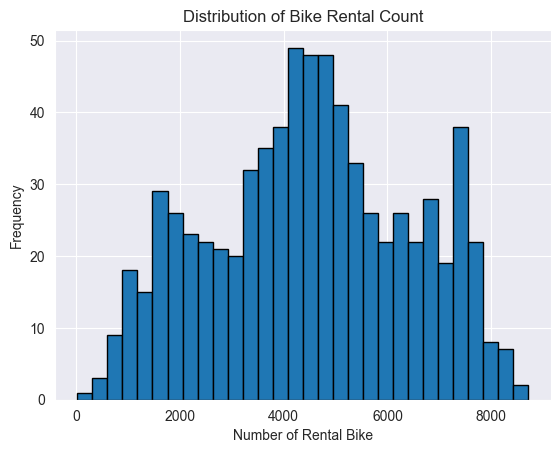

In [39]:
# Create a histogram to visualize the distribution of the 'cnt' column, which represents the bike rental counts.
# The histogram uses 30 bins to provide detailed frequency intervals, with edges colored black for clear distinction.
df['cnt'].hist(bins=30, edgecolor='black')
plt.title('Distribution of Bike Rental Count')
plt.xlabel('Number of Rental Bike')
plt.ylabel('Frequency')
plt.show()

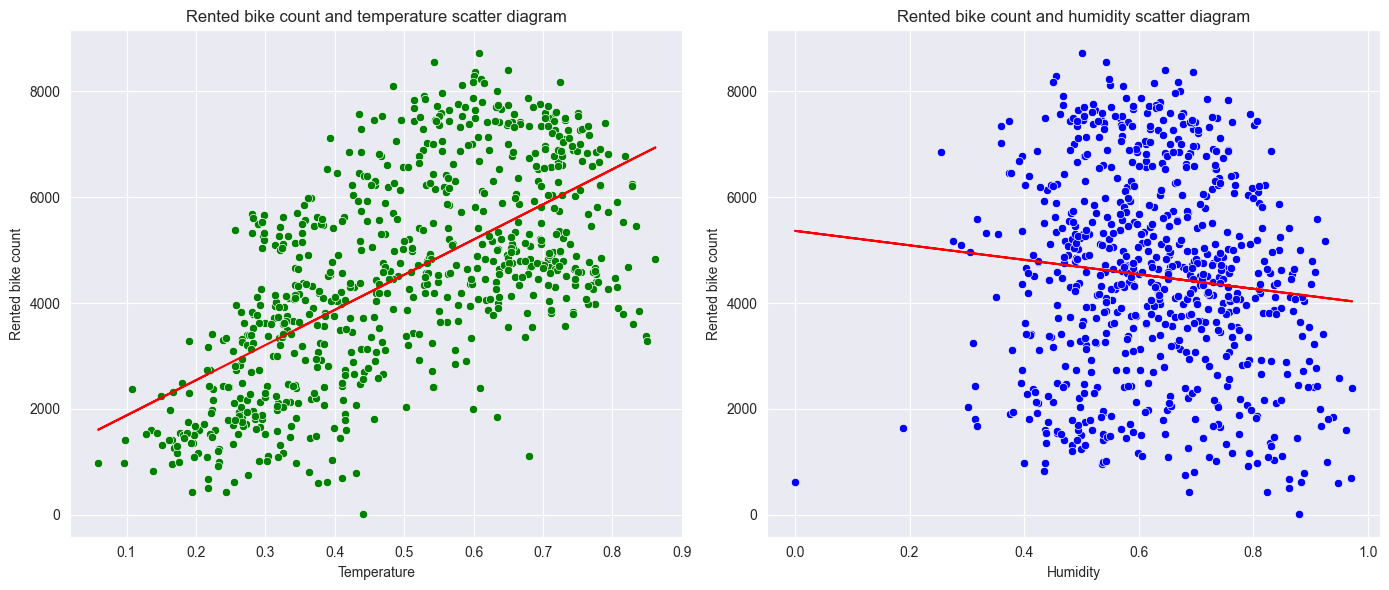

In [40]:
# Set up a matplotlib figure with two subplots arranged horizontally, setting the overall figure size
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Subplot A: Scatter plot of Temperature vs Rented Bike Count
# Visualize relationship between temperature ('temp') and bike rental count ('cnt')
sns.scatterplot(ax=axes[0], data=df, x='temp', y='cnt', color='green')
axes[0].set_title('Rented bike count and temperature scatter diagram')
axes[0].set_xlabel('Temperature')
axes[0].set_ylabel('Rented bike count')

# Calculate and plot the best-fit line (linear regression) to illustrate trend between temperature and rentals
z_temp = np.polyfit(df['temp'], df['cnt'], 1) # polynomial fit of degree 1 (linear)
p_temp = np.poly1d(z_temp)  # create polynomial function
axes[0].plot(df['temp'], p_temp(df['temp']), color='red')  # plot regression line in red

# Subplot B: Scatter plot of Humidity vs Rented Bike Count
# Visualize relationship between humidity ('hum') and bike rental count ('cnt')
sns.scatterplot(ax=axes[1], data=df, x='hum', y='cnt', color='blue')
axes[1].set_title('Rented bike count and humidity scatter diagram')
axes[1].set_xlabel('Humidity')
axes[1].set_ylabel('Rented bike count')

# Calculate and plot the best-fit line (linear regression) to illustrate trend between humidity and rentals
z_hum = np.polyfit(df['hum'], df['cnt'], 1) # polynomial fit of degree 1 (linear)
p_hum = np.poly1d(z_hum)  # create polynomial function
axes[1].plot(df['hum'], p_hum(df['hum']), color='red') # plot regression line in red

# Adjust subplot layout to prevent overlapping elements and ensure clear visualization
plt.tight_layout()
# Display the plots
plt.show()

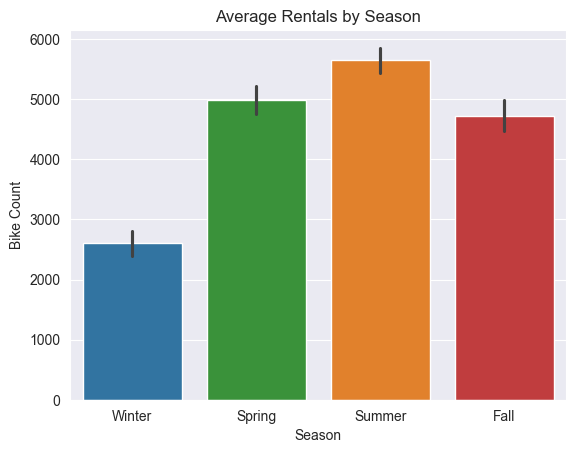

In [41]:
# Bar Chart: Visualizing Average Bike Rentals by Season
# Create a dictionary to map numerical season codes to readable names
season_labels = {
    1: "Winter",
    2: "Spring",
    3: "Summer",
    4: "Fall"
}

# Load original dataset to ensure data integrity for this visualization
df_original = pd.read_csv("day.csv")
# Add a new column 'season_name' with descriptive season names using the mapping dictionary
df_original['season_name'] = df_original['season'].map(season_labels)


# Define custom colors to visually distinguish each season clearly
colors = ['#1f77b4', '#2ca02c', '#ff7f0e', '#d62728']  # Blue, Green, Orange, Red
# Create a bar plot showing the average number of bike rentals for each season
sns.barplot(x='season_name', y='cnt', data=df_original, palette=colors)
# Add a clear title to the chart for immediate context
plt.title('Average Rentals by Season')
# Label the x-axis to identify the seasons
plt.xlabel('Season')
# Label the x-axis to identify the seasons
plt.ylabel('Bike Count')
# Display the final visualization clearly
plt.show()

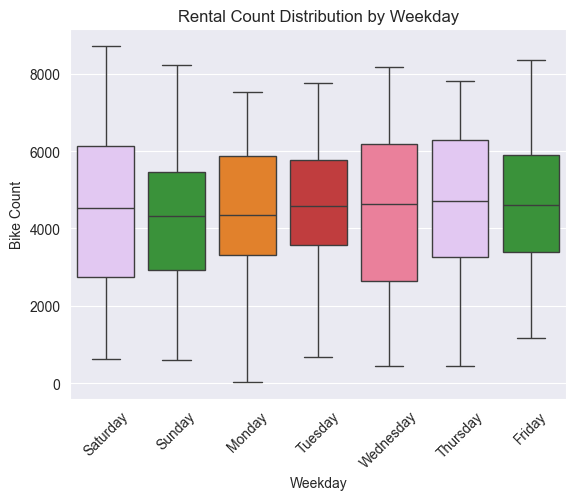

In [42]:
# Boxplot: Visualizing Bike Rental Count Distribution Grouped by Weekday

# Dictionary mapping numeric weekday codes to readable weekday names
weekday_labels = {
    0: "Sunday",
    1: "Monday",
    2: "Tuesday",
    3: "Wednesday",
    4: "Thursday",
    5: "Friday",
    6: "Saturday"
}

# Create a new column 'weekday_name' in the dataset for clearer interpretability
df_original['weekday_name'] = df_original['weekday'].map(weekday_labels)

# Plot boxplot grouped by weekday names
colors = ['#e4c1f9', '#2ca02c', '#ff7f0e', '#d62728', '#fb6f92']
sns.boxplot(x='weekday_name', y='cnt', data=df_original, palette=colors)
plt.title('Rental Count Distribution by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Bike Count')
plt.xticks(rotation=45)
plt.show()

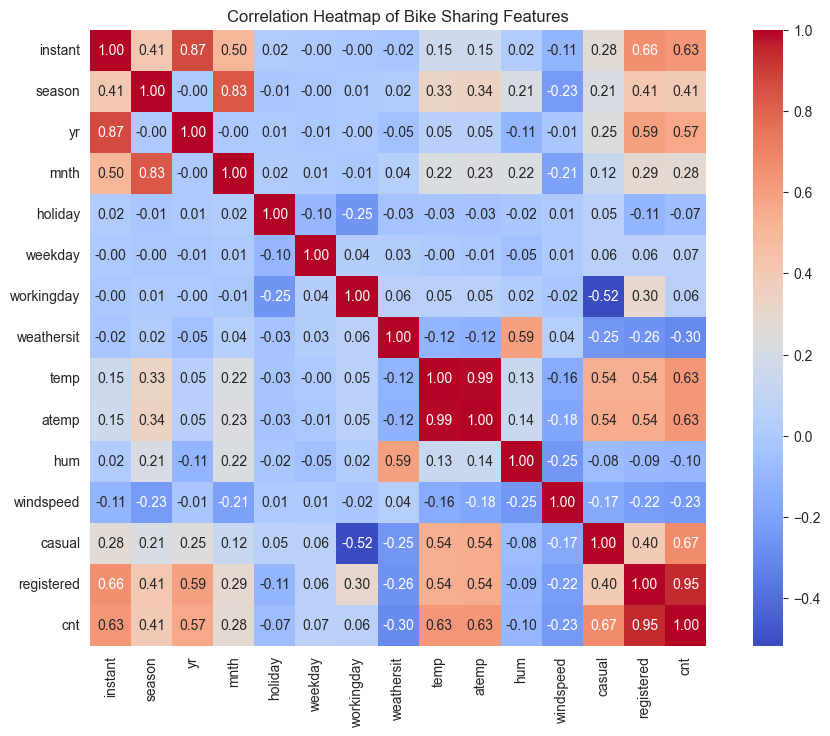

In [43]:
# Calculate the correlation matrix for numerical features in the dataset,
# excluding the 'dteday' column as dates do not have numeric correlation significance.
corr_matrix = df.drop(columns=["dteday"]).corr()

# Plot heatmap
# Generate a heatmap to visually represent the correlation matrix.
# This plot provides insights into the strength and direction (positive or negative)
# of relationships between different features.
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap of Bike Sharing Features")
plt.show()

## 3. Preprocessing

In [44]:
# Drop unnecessary columns from the dataset to reduce noise and avoid data leakage:
# - 'instant': an index-like identifier, not useful for prediction
# - 'dteday': a date column not suitable for correlation-based models without transformation
# - 'casual' and 'registered': components of the target variable 'cnt'; keeping them would lead to data leakage
df.drop(columns=["instant", "dteday", "casual", "registered"], inplace=True)

# Display the first five rows of the cleaned dataset to verify the result
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,0.34,0.36,0.81,0.16,985
1,1,0,1,0,0,0,2,0.36,0.35,0.70,0.25,801
2,1,0,1,0,1,1,1,0.20,0.19,0.44,0.25,1349
3,1,0,1,0,2,1,1,0.20,0.21,0.59,0.16,1562
4,1,0,1,0,3,1,1,0.23,0.23,0.44,0.19,1600


In [45]:
# Remove duplicate rows
initial_shape = df.shape
df.drop_duplicates(inplace=True)
print(f"Dropped {initial_shape[0] - df.shape[0]} duplicate rows.")

Dropped 0 duplicate rows.


In [46]:
# Check for missing values
missing = df.isnull().sum()
print("Missing values per column:")
print(missing)

# Handle missing values (fill numeric columns with mean)
if missing.any():
    df.fillna(df.mean(numeric_only=True), inplace=True)
    print("Filled missing values with column means.")

Missing values per column:
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
dtype: int64


In [47]:
# Define a list of categorical columns to be encoded using one-hot encoding.
# These features are categorical and need to be converted to numerical format for model training.
categorical_cols = ["season", "mnth", "weekday", "weathersit"]
# Apply one-hot encoding to the specified categorical columns.
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
# Display the first five rows of the updated DataFrame to verify one-hot encoding was applied correctly
df.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_2,season_3,season_4,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_2,weathersit_3
0,0,0,0,0.34,0.36,0.81,0.16,985,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False
1,0,0,0,0.36,0.35,0.70,0.25,801,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
2,0,0,1,0.20,0.19,0.44,0.25,1349,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
3,0,0,1,0.20,0.21,0.59,0.16,1562,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
4,0,0,1,0.23,0.23,0.44,0.19,1600,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False


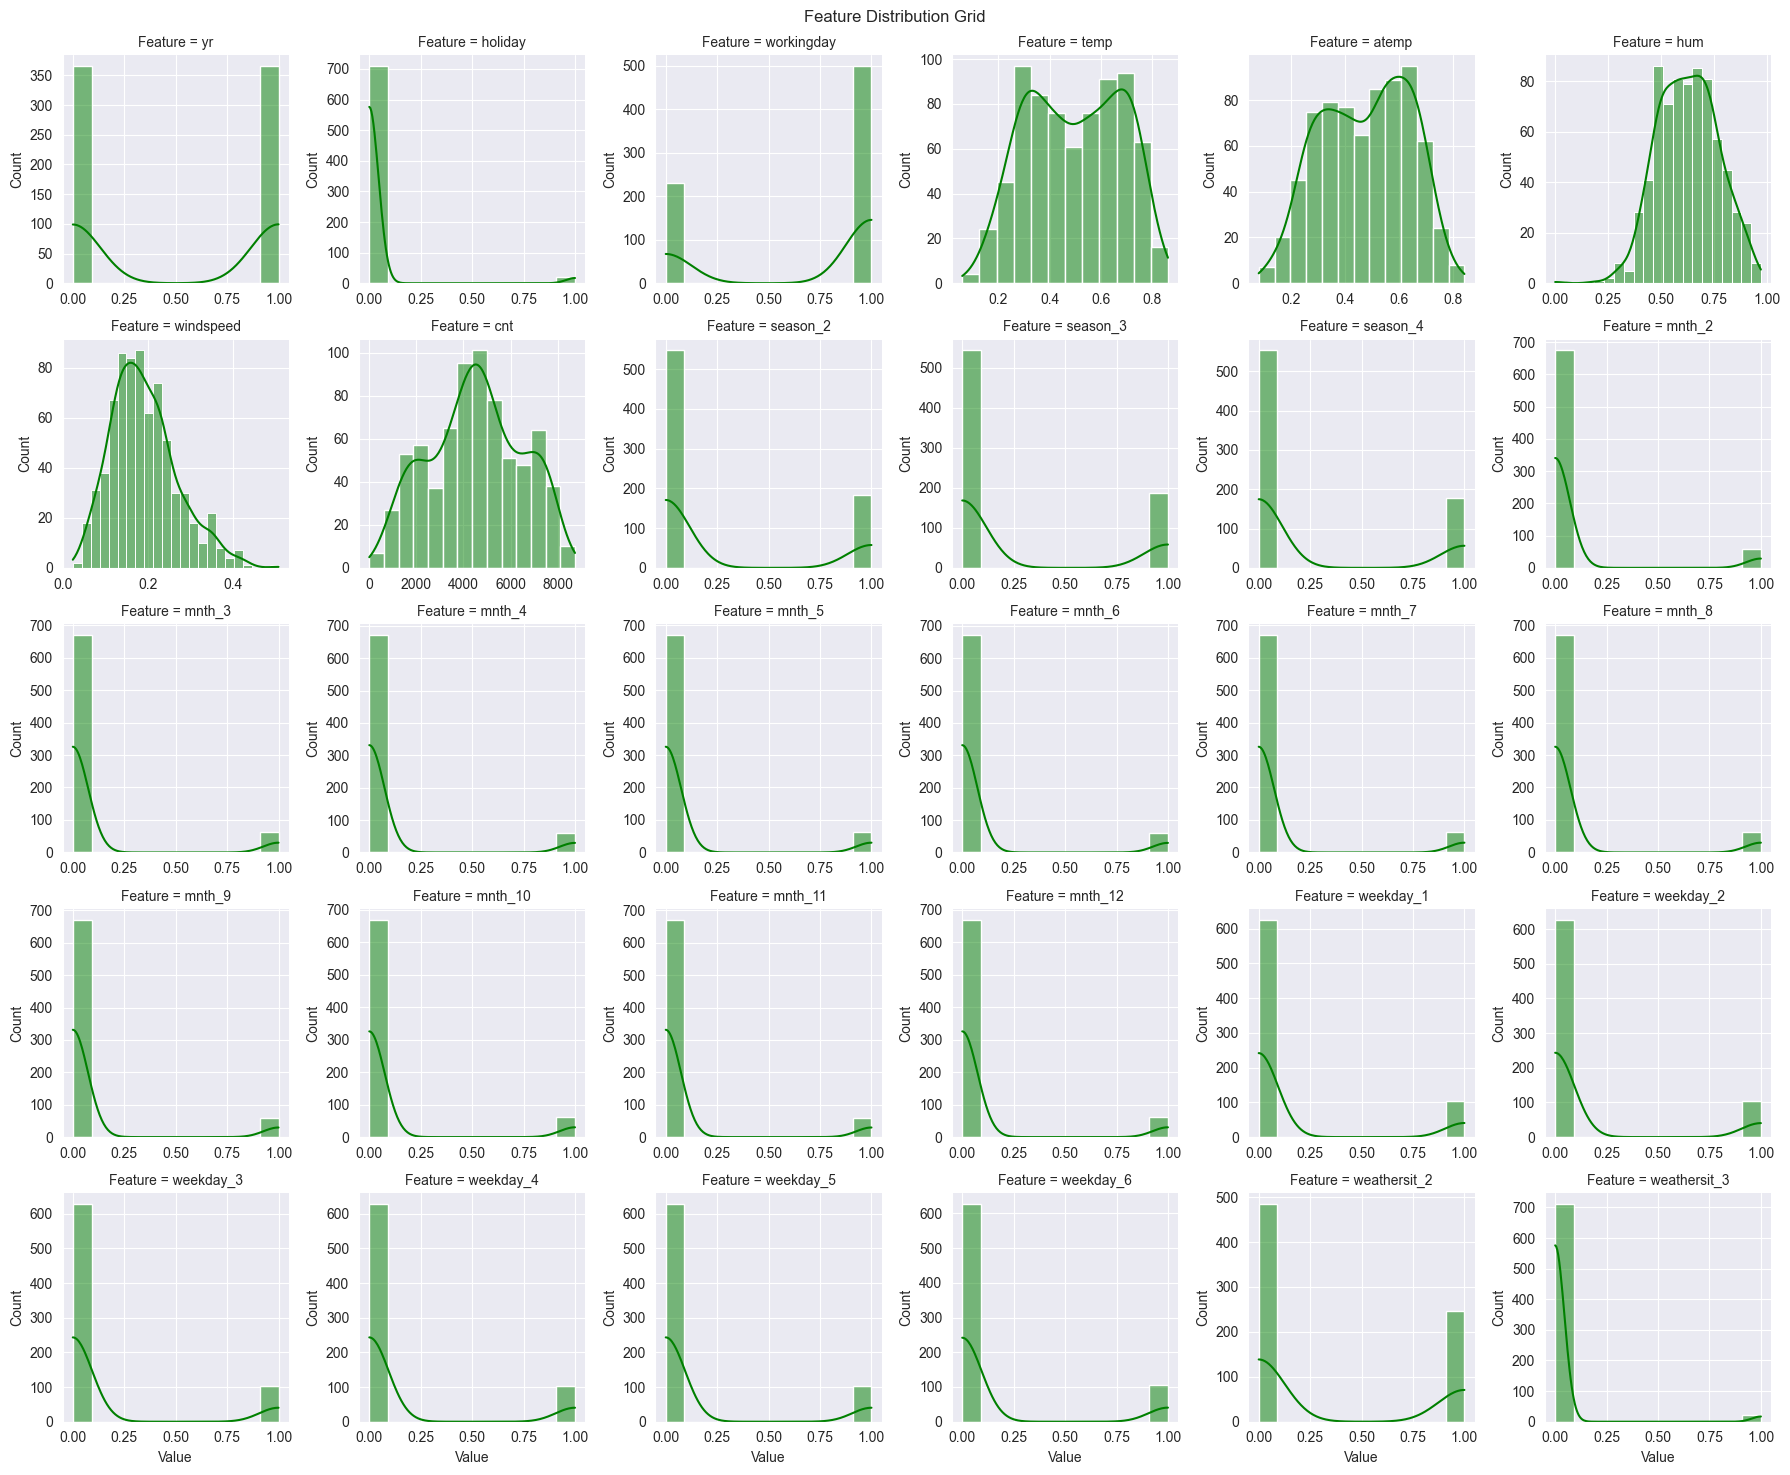

In [48]:
# Visualize the distribution of all features by reshaping the dataset into long format
# and plotting individual histograms with KDE for each feature using a FacetGrid.
# This helps to quickly assess the underlying distribution and spread of each variable.
df_melted = df.melt(var_name='Feature', value_name='Value')
g = sns.FacetGrid(df_melted, col='Feature', col_wrap=6, sharex=False, sharey=False)
g.map(sns.histplot, "Value", kde=True, color="green")
plt.subplots_adjust(top=0.95)
g.fig.suptitle("Feature Distribution Grid")
plt.show()

In [49]:
# Split the dataset into features (X) and target variable (y),
# and then divide it into training and testing sets for model training and evaluation.

# Separate the input features (independent variables) from the target variable ('cnt')
X = df.drop("cnt", axis=1)  # 'X' contains all columns except 'cnt'
y = df["cnt"]               # 'y' contains the target: bike rental count

# Split the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [50]:
# Standardize the feature values to have zero mean and unit variance,
# which helps improve the performance and convergence speed of many machine learning algorithms.

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Use the same scaler to transform the test data (to avoid data leakage)
X_test_scaled = scaler.transform(X_test)

## 4. Train Initial HistGradientBoosting Regressor

In [51]:
# Train and evaluate the HistGradientBoostingRegressor model,
# and calculate key regression performance metrics on the test set.

model = HistGradientBoostingRegressor(random_state=42)
model.fit(X_train_scaled, y_train)

# Predict target values on the scaled test set
y_pred = model.predict(X_test_scaled)

# Calculate performance metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Print the model's R² score on training and testing sets
print('The regression score on training data : {:.2f}'.format(model.score(X_train_scaled, y_train)))
print('The regression score on testing data  : {:.2f}'.format(model.score(X_test_scaled, y_test)))

# Print the calculated error metrics
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

The regression score on training data : 0.97
The regression score on testing data  : 0.91
MAE: 391.83
RMSE: 540.70
R²: 0.91


## 5. Plot Predicted vs Actual

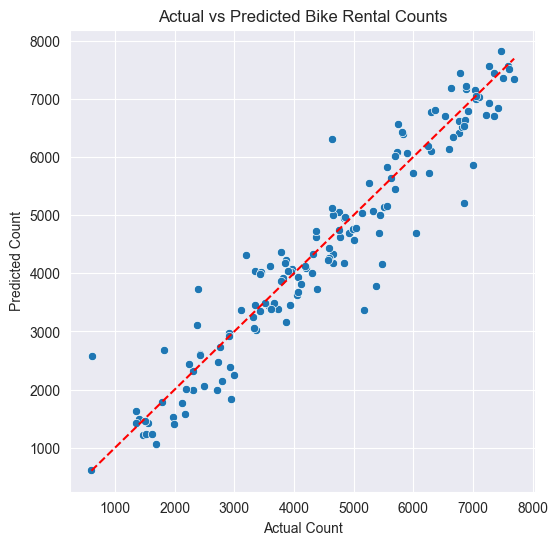

In [52]:
# Visualize the relationship between actual and predicted bike rental counts
# to assess the model’s prediction accuracy and bias.

# Set figure size for better visibility
plt.figure(figsize=(6, 6))

# Scatter plot of actual vs predicted values
sns.scatterplot(x=y_test, y=y_pred)

# Label the axes for clarity
plt.xlabel("Actual Count")
plt.ylabel("Predicted Count")
plt.title("Actual vs Predicted Bike Rental Counts")

# Plot a reference diagonal line (y = x) in red dashed style
# Perfect predictions would lie along this line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')

# Display the plot
plt.show()

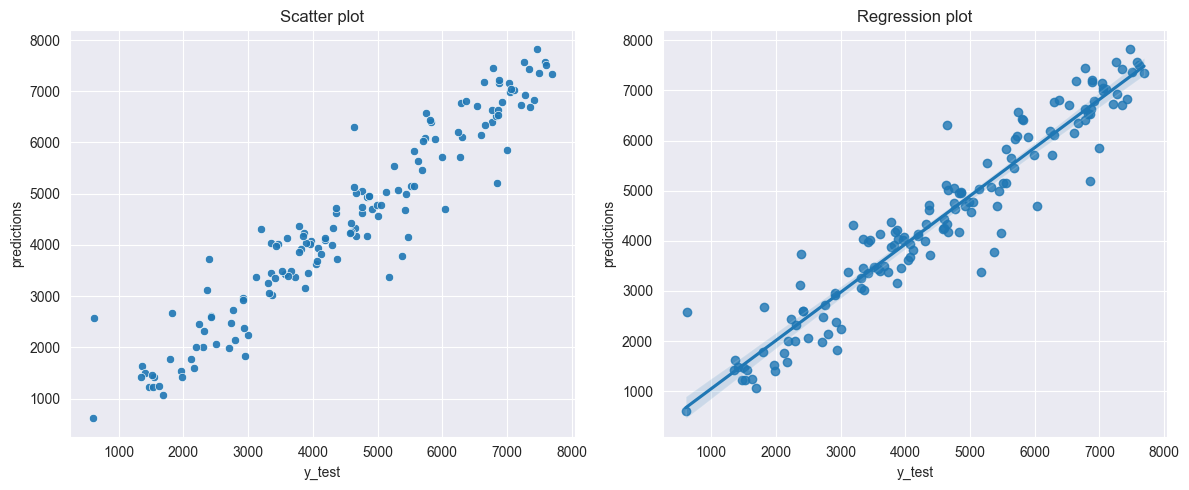

In [53]:
# Visualize prediction performance using scatter and regression plots to assess prediction accuracy and linearity
plt.figure(figsize=(12,5))
sns.set_style("darkgrid")

# Left subplot: Simple scatter plot of actual vs predicted values ---
plt.subplot(1,2,1)
sns.scatterplot(x=y_test, y=y_pred, alpha=0.9)
plt.xlabel('y_test')
plt.ylabel('predictions')
plt.title('Scatter plot')

# Right subplot: Regression plot with best-fit line ---
plt.subplot(1,2,2)
sns.regplot(x=y_test, y=y_pred)
plt.xlabel('y_test')
plt.ylabel('predictions')
plt.title('Regression plot')

# Adjust subplot layout to prevent overlap
plt.tight_layout()

# Display both subplots
plt.show()

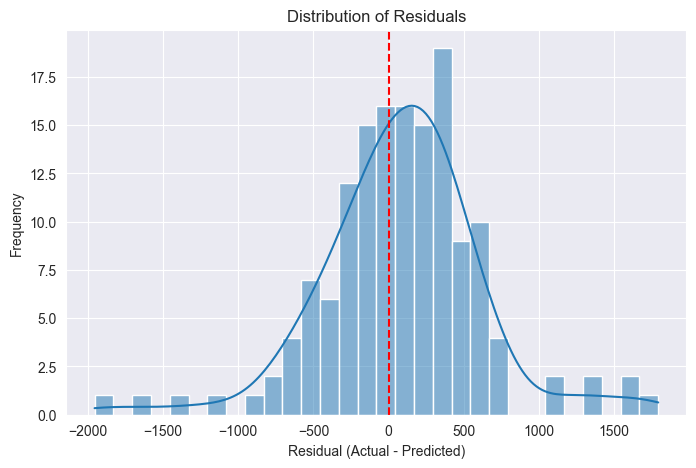

In [54]:
# Analyze the distribution of residuals (errors) to assess the model's prediction bias and variance

# Calculate residuals: the difference between actual and predicted values
residuals = y_test - y_pred

# Set up the plot figure size
plt.figure(figsize=(8, 5))

# Plot histogram with KDE to visualize the residual distribution
sns.histplot(residuals, kde=True, bins=30)

# Add plot title and axis labels for clarity
plt.title("Distribution of Residuals")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")

# Draw a vertical reference line at 0 to indicate perfect prediction
plt.axvline(0, color='red', linestyle='--')

# Show the plot
plt.show()

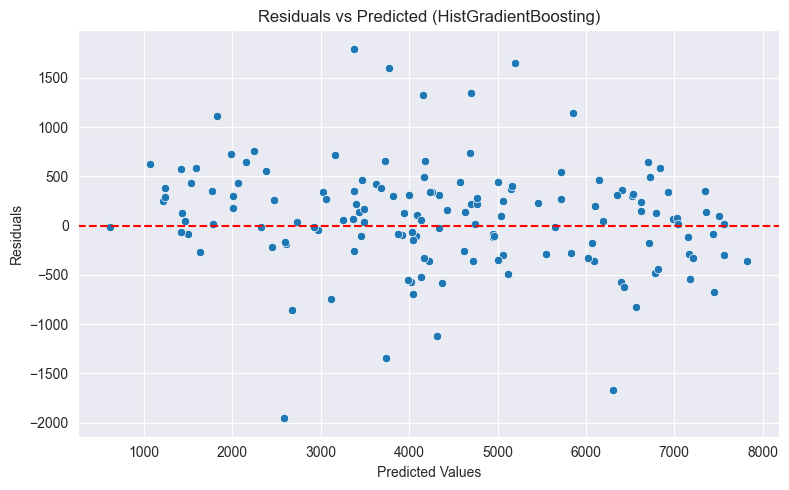

In [55]:
# Plot residuals against predicted values to assess homoscedasticity and identify patterns in prediction errors

plt.figure(figsize=(8, 5)) # Set the figure size for readability

# Create a scatter plot of predicted values vs residuals (errors)
sns.scatterplot(x=y_pred, y=residuals)

# Add a horizontal line at zero to serve as a reference for perfect predictions
plt.axhline(0, color='red', linestyle='--')

# Label the axes
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")

# Add a title to provide context
plt.title("Residuals vs Predicted (HistGradientBoosting)")

# Adjust the layout to avoid overlap
plt.tight_layout()

# Adjust the layout to avoid overlap
plt.show()

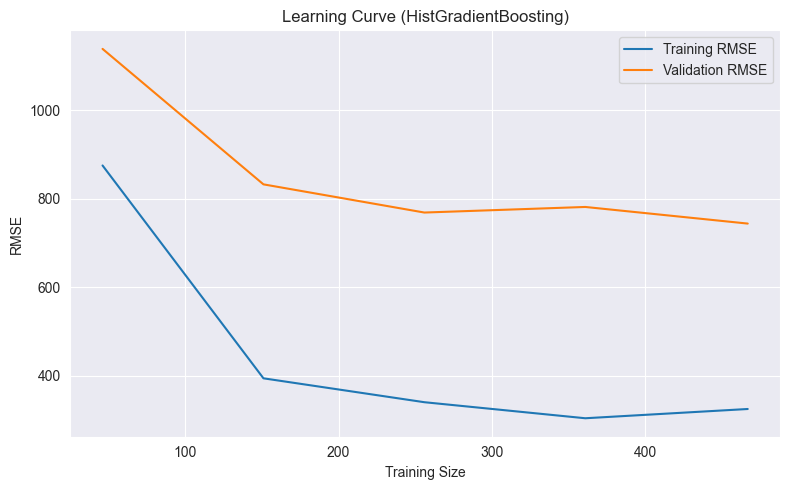

In [56]:
# Plot a learning curve to analyze model performance as training size increases,
# helping identify issues like overfitting or underfitting.

# Compute training and validation scores using cross-validation with varying training set sizes
train_sizes, train_scores, test_scores = learning_curve(
    model, X_train_scaled, y_train, cv=5, scoring="neg_mean_squared_error", train_sizes=np.linspace(0.1, 1.0, 5), random_state=42
)

# Convert negative MSE to RMSE for interpretability
train_rmse = np.sqrt(-train_scores)
test_rmse = np.sqrt(-test_scores)

# Plot the learning curve
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_rmse.mean(axis=1), label="Training RMSE")
plt.plot(train_sizes, test_rmse.mean(axis=1), label="Validation RMSE")
plt.xlabel("Training Size")
plt.ylabel("RMSE")
plt.title("Learning Curve (HistGradientBoosting)")
plt.legend()
plt.tight_layout()
plt.show()

## 6. Feature Importance

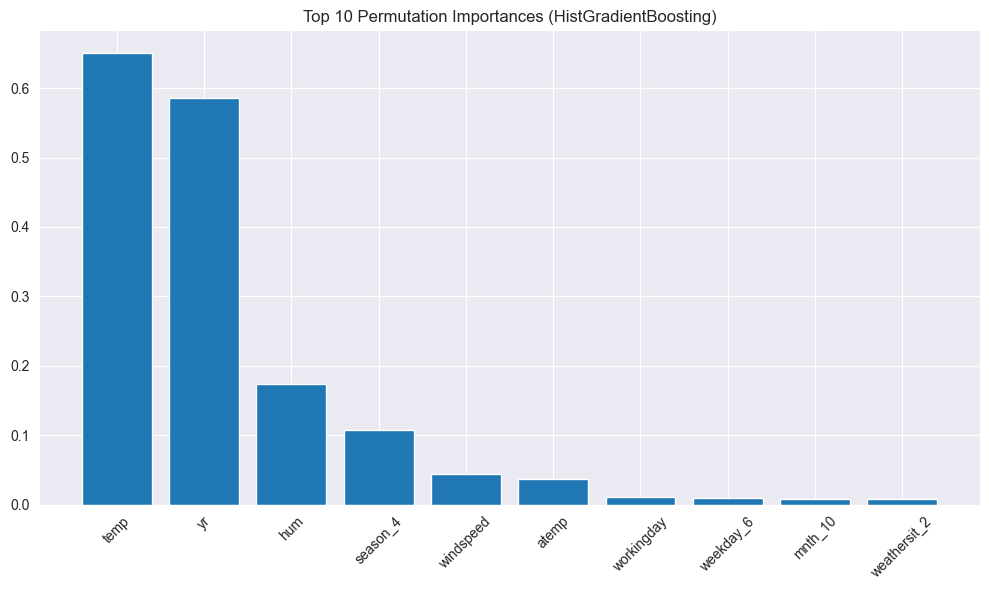

In [57]:
# Assess feature importance using permutation importance, which evaluates how model performance
# changes when each feature’s values are randomly shuffled (thus breaking its relationship with the target).

# Compute permutation importance on the test set
result = permutation_importance(model, X_test_scaled, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Sort features by their average importance scores in descending order
sorted_idx = result.importances_mean.argsort()[::-1]

# Plot the top 10 most important features
plt.figure(figsize=(10, 6))
plt.bar(range(10), result.importances_mean[sorted_idx[:10]])
plt.xticks(range(10), X_train.columns[sorted_idx[:10]], rotation=45)
plt.title("Top 10 Permutation Importances (HistGradientBoosting)")
plt.tight_layout()
plt.show()

## 7. Model Comparison

In [58]:
# Define models
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "Bagging Regressor": BaggingRegressor(random_state=42),
    "HistGradientBoosting": HistGradientBoostingRegressor(random_state=42),
    "Extra Trees": ExtraTreesRegressor(random_state=42),
    "AdaBoost": AdaBoostRegressor(random_state=42),
    "KNN Regressor": KNeighborsRegressor(),
    "XGBoost": XGBRegressor(objective='reg:squarederror', random_state=42)
}

In [59]:
# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results[name] = {"RMSE": rmse, "MAE": mae, "R2": r2}

In [60]:
# Create DataFrame
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values(by="R2", ascending=False)

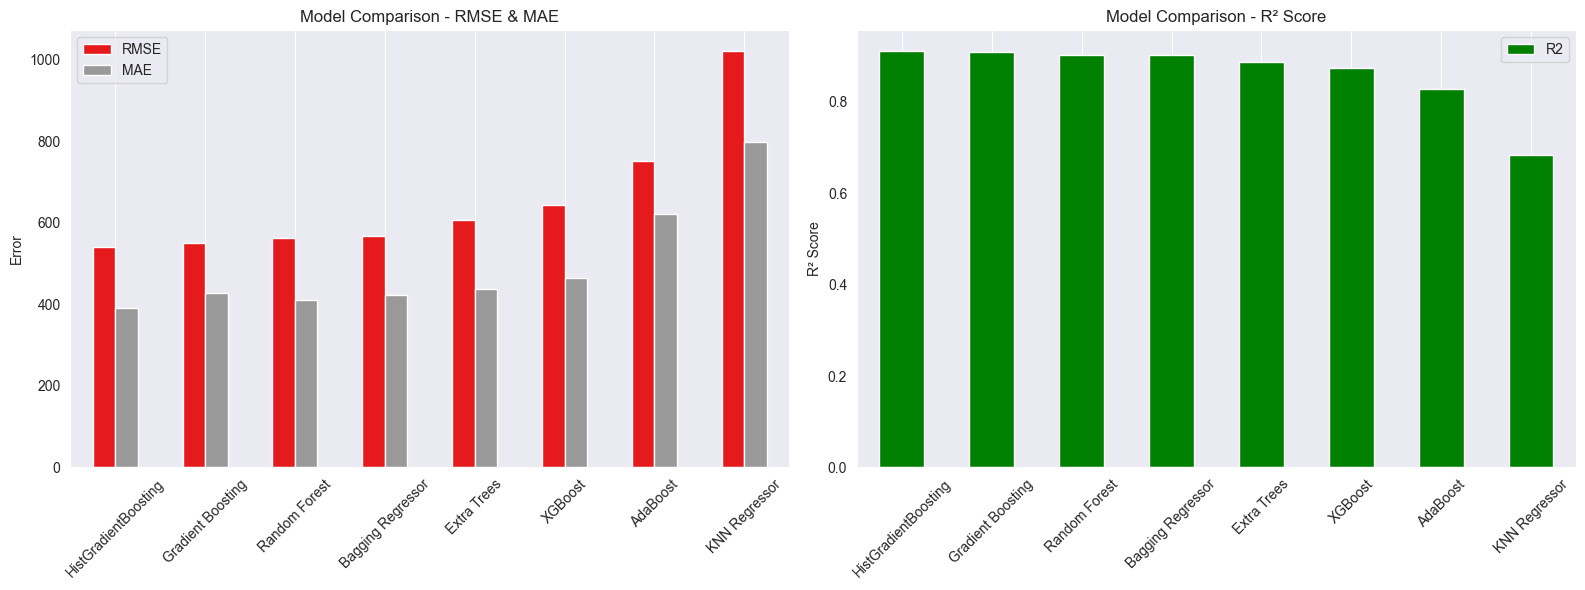

In [61]:
# Plot using two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot RMSE & MAE
results_df[["RMSE", "MAE"]].plot(kind='bar', ax=axes[0], colormap='Set1')
axes[0].set_title("Model Comparison - RMSE & MAE")
axes[0].set_ylabel("Error")
axes[0].set_xticklabels(results_df.index, rotation=45)
axes[0].grid(axis='y')

# Plot R2 separately
results_df[["R2"]].plot(kind='bar', ax=axes[1], color='green')
axes[1].set_title("Model Comparison - R² Score")
axes[1].set_ylabel("R² Score")
axes[1].set_xticklabels(results_df.index, rotation=45)
axes[1].grid(axis='y')

plt.tight_layout()
plt.show()


In [62]:
# Display results table
results_df

,RMSE,MAE,R2
HistGradientBoosting,540.70,391.83,0.91
Gradient Boosting,549.50,428.74,0.91
Random Forest,563.30,410.50,0.90
Bagging Regressor,567.98,422.31,0.90
Extra Trees,607.21,437.32,0.89
XGBoost,644.30,464.32,0.87
AdaBoost,750.88,620.17,0.83
KNN Regressor,1020.29,797.10,0.68
